In [163]:
import numpy as np
import zarr
import matplotlib.pyplot as plt

RUNTIME = 1800 #seconds
# root = zarr.open("/mnt/c/Users/Anthony/Desktop/test.zarr", mode="r")
# test = zarr.open("../../results_GOOD.zarr", mode="r")
# test = zarr.open("/mnt/c/Users/Anthony/Desktop/results_attrition1.zarr", mode="r")
# test.tree()
# print([i/1.0e9 for i in test["cumberland_6"]["AHPA"]["run_1"]["attrition_times"]])

In [164]:
def analyzeRun(run: zarr.hierarchy):
    # print(f"Analyze {run.name}")

    numNodes = run["graph"].shape[0]
    numAgents = run["origins"].shape[0]

    times = np.array(run["visits"]["time_ns"]) / 1.0e9 #seconds to ns
    data = np.transpose(np.vstack([times, run["visits"]["agent"], run["visits"]["node"]]))
    # print(data.shape)
    # print(data[np.where(data[:,2] == 5)])

    # print(f"Attrition times: {[(i/1.0e9, j) for i,j in run['attrition_times']]}")

    idleness = np.ndarray((RUNTIME + 1, numNodes + 1))
    idleness[:,0] = range(RUNTIME + 1)
    for i in range(numNodes):
        nodeVisits = data[np.where(data[:,2] == i)]

        # Add beginning and end.
        nodeVisits = np.append([[0, 0, i]], nodeVisits, axis=0)
        nodeVisits = np.append(nodeVisits, [[RUNTIME, 0, i]], axis=0)

        # nodeIdleness = []
        idl = 0.0
        visitIdx = 0

        for t in range(RUNTIME + 1):
            if visitIdx + 1 < nodeVisits.shape[0] and t > nodeVisits[visitIdx + 1][0]:
                visitIdx += 1
            idl = t - nodeVisits[visitIdx][0] 
            idleness[t][i + 1] = idl
    
    messages = np.ndarray((RUNTIME + 1, 1))
    commTimes = np.array(run["comm_times"]) / 1.0e9
    for i in range(RUNTIME + 1):
        messages[i] = np.count_nonzero(commTimes < i)

    return idleness, messages

def analyzeAlg(alg):
    idleness = np.ndarray((RUNTIME + 1, 1))
    idleness[:,0] = range(RUNTIME + 1)
    messages = np.ndarray((RUNTIME + 1, 1))
    messages[:,0] = range(RUNTIME + 1)
    for run in alg:
        idl, msgs = analyzeRun(alg[run])
        # displayAverageIdleness([idl], ["idleness"], title=f"{alg.name}/{run}", attrition=bool(alg[run]["attrition_times"].size > 0))
        idleness = np.concatenate([idleness, idl[:,1:]], axis=1)
        messages = np.concatenate([messages, msgs], axis=1)
    return idleness, messages

def analyzeFile(filePath, attritionTimes=[]):
    root = zarr.open(filePath, mode="r")
    mapName = "cumberland_6"
    labels = []
    results = []
    msgResults = []
    for algName in root[mapName]:
        try:
            idleness, messages = analyzeAlg(root[mapName][algName])
        except KeyError as e:
            print(f"A run for algorithm {algName} has invalid data!")
            raise
        results.append(idleness)
        msgResults.append(messages)
        labels.append(algName)
    
    displayAverageIdleness(results, labels, attritionTimes=attritionTimes)
    displayStdIdleness(results, labels, attritionTimes=attritionTimes)
    displayMessages(msgResults, labels, attritionTimes=attritionTimes)

PLOT_X = 10
PLOT_Y = 6
def displayAverageIdleness(inputs, labels, attritionTimes=[],
        title="Average Node Idleness vs. Time"
    ):
    plt.figure(figsize=(PLOT_X, PLOT_Y))
    for arr, name in zip(inputs, labels):
        plt.plot(np.mean(arr[:,1:], axis=1), label=name)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Average Node Idleness (s)")
    if len(attritionTimes) > 0:
        plt.title(f"{title} (With Attrition)")
        for t in attritionTimes:
            plt.axvline(t, color="black", ls="-")
            plt.text(t + 0.1,0,'attrition',rotation=90)
    else:
        plt.title(f"{title} (No Attrition)")
    plt.show()

def displayStdIdleness(inputs, labels, attritionTimes=[]):
    plt.figure(figsize=(PLOT_X, PLOT_Y))
    for arr, name in zip(inputs, labels):
        plt.plot(np.std(arr[:,1:], axis=1), label=name)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Std. Dev. of Node Idleness (s)")
    if len(attritionTimes) > 0:
        plt.title("Std. Dev. of Node Idleness vs. Time (With Attrition)")
        for t in attritionTimes:
            plt.axvline(t)
            plt.text(t + 0.1,0,'attrition',rotation=90)
    else:
        plt.title("Std. Dev. of Node Idleness vs. Time (No Attrition)")
    plt.show()

def displayMessages(inputs, labels, attritionTimes=[],
        title="Messages Broadcast vs. Time"
    ):
    plt.figure(figsize=(PLOT_X, PLOT_Y))
    for arr, name in zip(inputs, labels):
        plt.plot(np.mean(arr[:,1:], axis=1), label=name)
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Cumulative Messages")
    if len(attritionTimes) > 0:
        plt.title(f"{title} (With Attrition)")
        for t in attritionTimes:
            plt.axvline(t)
            plt.text(t + 0.1,0,'attrition',rotation=90)
    else:
        plt.title(f"{title} (No Attrition)")
    plt.show()

# analyzeRun(zarr.open("/mnt/c/Users/Anthony/Desktop/results_noattrit3.zarr", "r")["cumberland_6"]["DTAGreedy"]["run_1"])

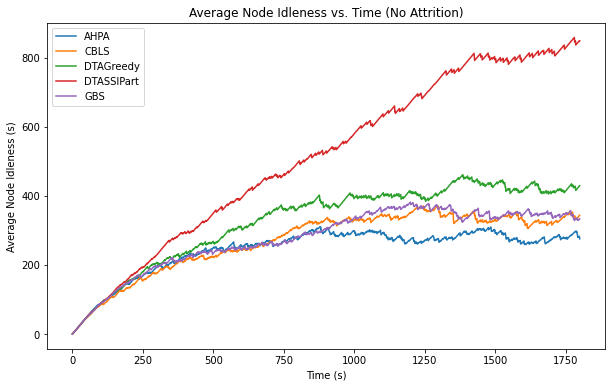

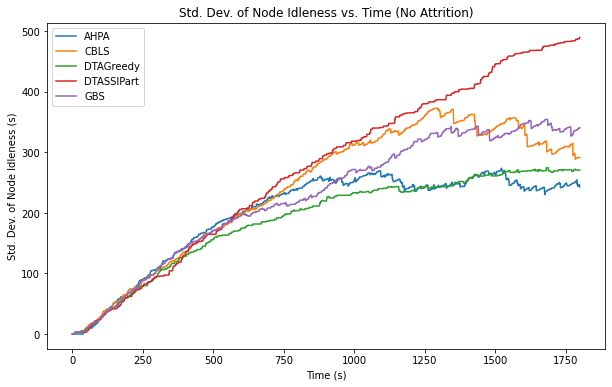

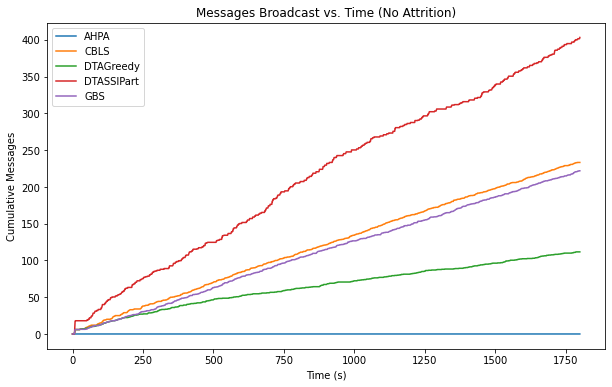

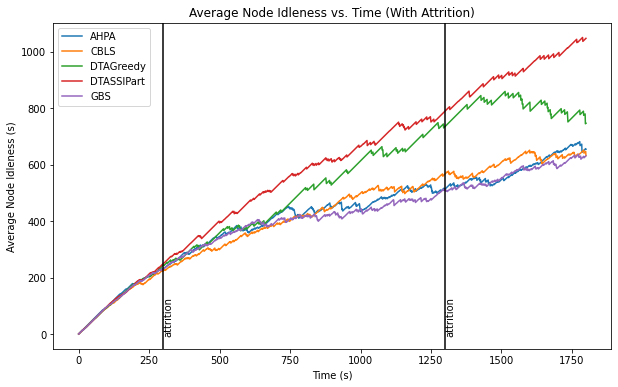

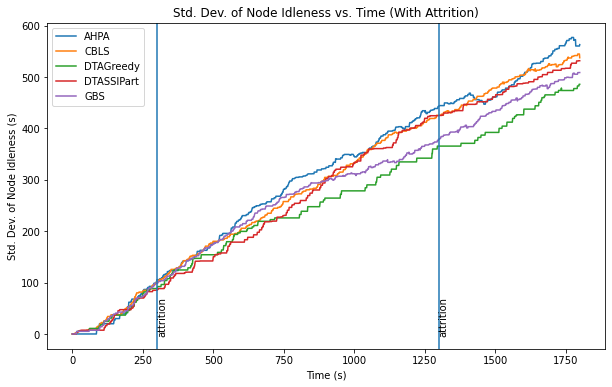

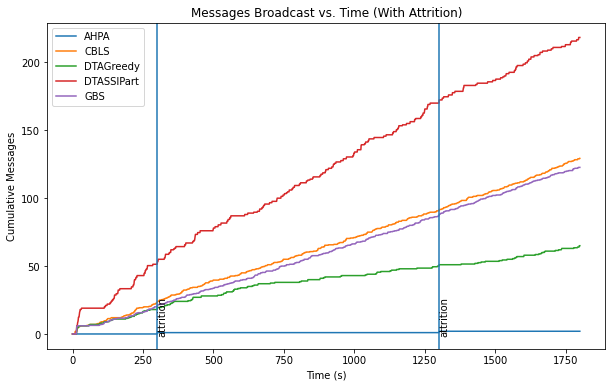

In [165]:
#attrition times 1: 300, 1300
#attrition times 2:
#attrition times 3: 1150

# analyzeFile("/mnt/c/Users/Anthony/Desktop/results_noattrit1.zarr")
# analyzeFile("/mnt/c/Users/Anthony/Desktop/results_noattrit2.zarr")
analyzeFile("/mnt/c/Users/Anthony/Desktop/results_noattrit3.zarr") # USE IN PAPER
analyzeFile("/mnt/c/Users/Anthony/Desktop/results_attrition1.zarr", attritionTimes=[300, 1300]) # USE IN PAPER
# analyzeFile("/mnt/c/Users/Anthony/Desktop/results_attrition2.zarr", attritionTimes=[1150])
# analyzeFile("/mnt/c/Users/Anthony/Desktop/results_attrition3.zarr", attritionTimes=[1150])